In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop,SGD
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/My\Drive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

In [ ]:
dir_ = Path('data')
filepaths = list(dir_.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')
df = pd.concat([filepaths, labels], axis=1)
df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

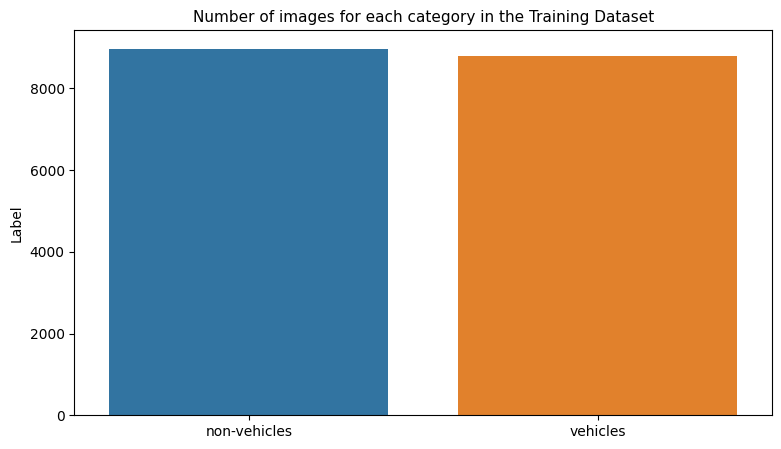

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

In [ ]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'vehicles')

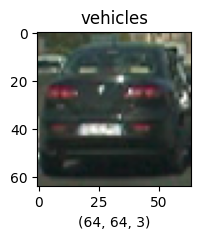

In [ ]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'non-vehicles')

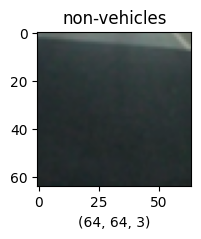

In [ ]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][15])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][15])

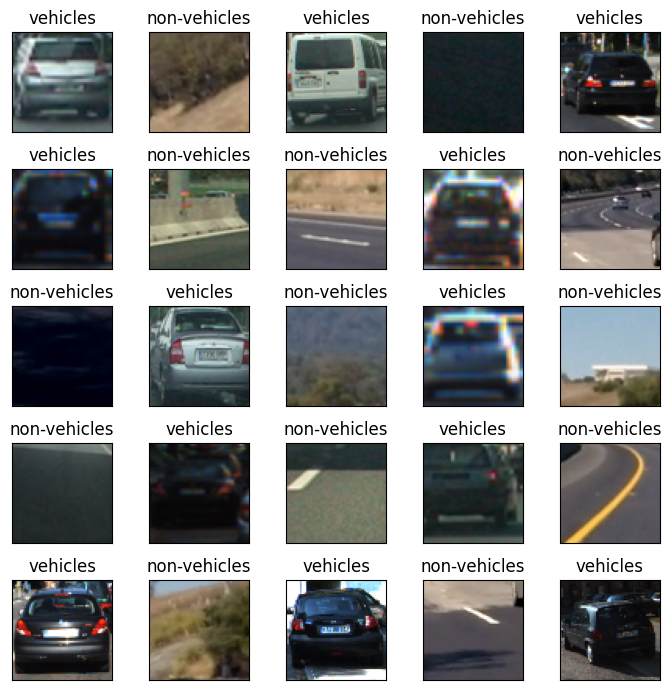

In [ ]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [ ]:
trainset_df, testset_df = train_test_split(df, train_size = 0.80, random_state = 42)

display(trainset_df.head())

testset_df.head()

,File,Label
15610,data/non-vehicles/extra5346.png,non-vehicles
5230,data/vehicles/3129.png,vehicles
15224,data/non-vehicles/image1647.png,non-vehicles
83,data/vehicles/1142.png,vehicles
14570,data/vehicles/2383.png,vehicles


,File,Label
15314,data/vehicles/5594.png,vehicles
11728,data/vehicles/3799.png,vehicles
10379,data/non-vehicles/extra3199.png,non-vehicles
6323,data/non-vehicles/extra4687.png,non-vehicles
5155,data/non-vehicles/extra1152.png,non-vehicles


In [ ]:
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [ ]:
 #Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with non vehicles: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with vehicles: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images of non vehicles: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with vehicles: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 14208
Number of images with non vehicles: 7197
Number of images with vehicles: 7011

Test Dataset:
Number of images: 3552
Number of images of non vehicles: 1781
Number of images with vehicles: 1771



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (299, 299),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (299, 299),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")
print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (299, 299),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')


Preparing the training dataset ...
Found 12788 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1420 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 3552 validated image filenames belonging to 2 classes.
Data generators are ready!


In [ ]:
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

In [ ]:
base_model= InceptionV3(input_shape = (299,299, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
x = layers.Flatten()(base_model.output)

In [ ]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(2, activation='softmax')(x)

model= Model(base_model.input, x)

In [ ]:
model.compile(optimizer = RMSprop(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
History = model.fit(training_set, epochs = 5, validation_data = validation_set)


Epoch 1/5
400/400 [==============================] - 415s 917ms/step - loss: 1.0516 - accuracy: 0.8768 - val_loss: 1.7443 - val_accuracy: 0.8092
Epoch 2/5
400/400 [==============================] - 358s 894ms/step - loss: 0.0765 - accuracy: 0.9770 - val_loss: 0.0364 - val_accuracy: 0.9915
Epoch 3/5
400/400 [==============================] - 358s 894ms/step - loss: 0.0423 - accuracy: 0.9857 - val_loss: 0.0631 - val_accuracy: 0.9859
Epoch 4/5
400/400 [==============================] - 369s 922ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.0185 - val_accuracy: 0.9930
Epoch 5/5
400/400 [==============================] - 359s 896ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.0947 - val_accuracy: 0.9718


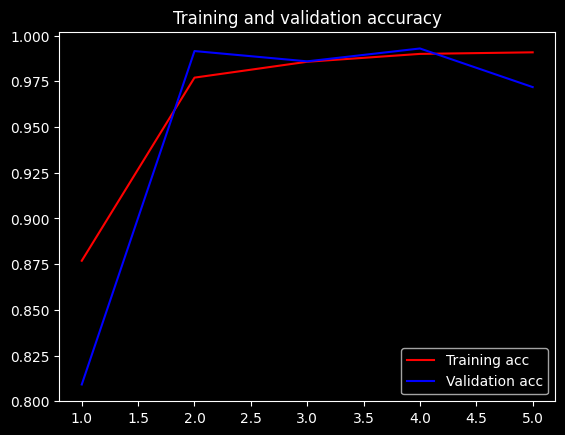

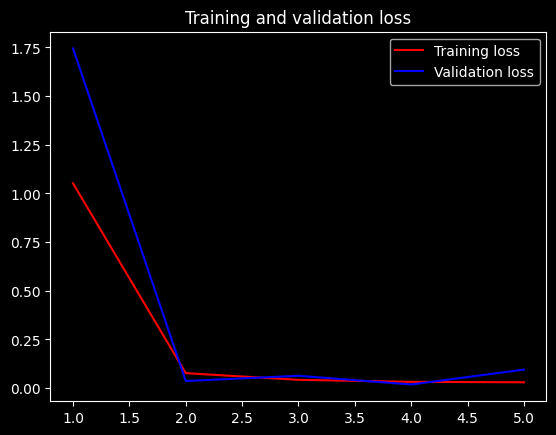

In [ ]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
score = model.evaluate(test_set)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

111/111 [==============================] - 18s 158ms/step - loss: 0.0719 - accuracy: 0.9741
Test Loss: 0.07193385809659958
Test Accuracy: 0.9740990996360779


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(299, 299,3))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # image path
    img_path = 'car.jpg'
    img_path2='tree.jpg'


    # load a single image
    new_image = load_image(img_path)
    new_image2 = load_image(img_path2)

    # check prediction
    pred = model.predict(new_image)
    print(pred)
    if(pred[0][0]<pred[0][1]):
      print("Vehicle")
    else:
      print("Not Vehicle")
    pred2 = model.predict(new_image2)
    print(pred2)
    if(pred2[0][0]<pred2[0][1]):
      print("Vehicle")
    else:
      print("Not Vehicle")

1/1 [==============================] - 3s 3s/step
[[3.8355683e-09 1.0000000e+00]]
Vehicle
1/1 [==============================] - 0s 26ms/step
[[0.959839   0.04016098]]
Not Vehicle


In [ ]:
print("Preparing the training dataset ...")
training_set2 = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (227, 227),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set2 = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (227, 227),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")
print("Preparing the test dataset ...")
test_set2 = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (227, 227),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')


Preparing the training dataset ...
Found 12788 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1420 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 3552 validated image filenames belonging to 2 classes.
Data generators are ready!


In [ ]:
model2= Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.4),
    Dense(4096, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=SGD(lr = 0.01), metrics=['accuracy'])

In [ ]:
History2=model2.fit(training_set2,epochs=5,validation_data=validation_set2)

Epoch 1/5
400/400 [==============================] - 181s 454ms/step - loss: 0.0820 - accuracy: 0.9673 - val_loss: 0.0969 - val_accuracy: 0.9627
Epoch 2/5
400/400 [==============================] - 172s 429ms/step - loss: 0.0702 - accuracy: 0.9740 - val_loss: 0.0424 - val_accuracy: 0.9838
Epoch 3/5
400/400 [==============================] - 174s 434ms/step - loss: 0.0575 - accuracy: 0.9794 - val_loss: 0.0705 - val_accuracy: 0.9732
Epoch 4/5
400/400 [==============================] - 172s 430ms/step - loss: 0.0430 - accuracy: 0.9845 - val_loss: 0.0302 - val_accuracy: 0.9908
Epoch 5/5
400/400 [==============================] - 174s 434ms/step - loss: 0.0362 - accuracy: 0.9868 - val_loss: 0.0538 - val_accuracy: 0.9789


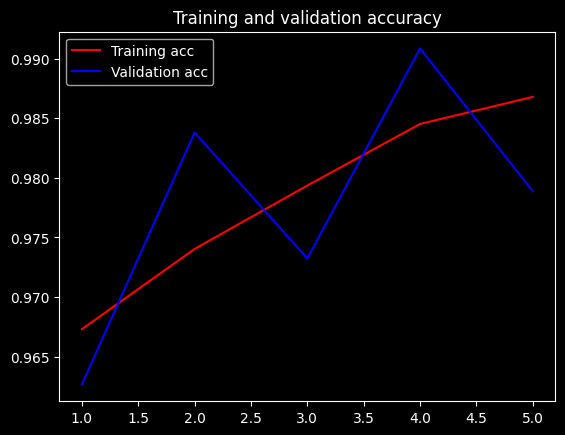

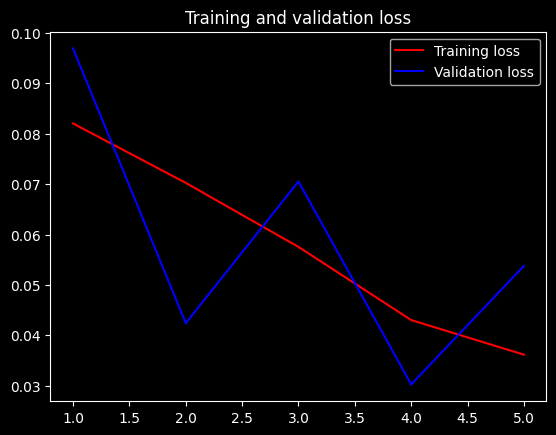

In [ ]:
acc = History2.history['accuracy']
val_acc = History2.history['val_accuracy']
loss = History2.history['loss']
val_loss = History2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
score2= model2.evaluate(test_set2)
print("Test Loss:", score2[0])
print("Test Accuracy:", score2[1])

111/111 [==============================] - 6s 51ms/step - loss: 0.0335 - accuracy: 0.9873
Test Loss: 0.03349616378545761
Test Accuracy: 0.9873310923576355


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(227, 227,3))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # image path
    img_path='car.jpg'
    img_path2 = 'tree.jpg'


    # load a single image
    new_image = load_image(img_path)
    new_image2 = load_image(img_path2)

    # check prediction
    pred = model2.predict(new_image)
    print(pred)
    if(pred[0][0]<pred[0][1]):
      print("Vehicle")
    else:
      print("Not Vehicle")
    pred2 = model2.predict(new_image2)
    print(pred2)
    if(pred2[0][0]<pred2[0][1]):
      print("Vehicle")
    else:
      print("Not Vehicle")

1/1 [==============================] - 0s 454ms/step
[[2.2429984e-05 9.9997759e-01]]
Vehicle
1/1 [==============================] - 0s 28ms/step
[[9.9997413e-01 2.5890087e-05]]
Not Vehicle
